### Installing Dependencies

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost --quiet

In [3]:
!pip install imbalanced-learn --upgrade --quiet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [7]:
# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)

### Loading the Dataset

In [9]:
data = pd.read_csv("C:/Users/ASUS/Downloads/Files_LPML/accepted_2007_to_2018Q4.csv", low_memory=False)
data.shape  # Check number of rows and columns

(2260701, 151)

### Data Insights

In [11]:
data.head()      # First few rows

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data.columns     # See all column names

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [15]:
data.info()      # Quick summary (types, nulls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [17]:
data.describe

<bound method NDFrame.describe of                                                        id  member_id  \
0                                                68407277        NaN   
1                                                68355089        NaN   
2                                                68341763        NaN   
3                                                66310712        NaN   
4                                                68476807        NaN   
...                                                   ...        ...   
2260696                                          88985880        NaN   
2260697                                          88224441        NaN   
2260698                                          88215728        NaN   
2260699  Total amount funded in policy code 1: 1465324575        NaN   
2260700   Total amount funded in policy code 2: 521953170        NaN   

         loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0           3600.0       36

#### Target variable

In [19]:
data['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

### Creating Binary Target

In [21]:
# Mark default-related statuses
default_statuses = [
    'Charged Off',
    'Late (31-120 days)',
    'Late (16-30 days)',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

# Create binary column
data['loan_default'] = data['loan_status'].apply(lambda x: 1 if x in default_statuses else 0)

# Check balance
data['loan_default'].value_counts(normalize=True)

loan_default
0    0.869432
1    0.130568
Name: proportion, dtype: float64

### Dropping Columns with too many missing Values

In [23]:
# Drop columns with >40% missing values
threshold = 0.4 * data.shape[0]
data = data.dropna(thresh=threshold, axis=1)

print("Remaining columns after dropping high-missing ones:", data.shape[1])

Remaining columns after dropping high-missing ones: 110


### Dropping Irrelevant Columns

In [25]:
#These columns won’t be available at loan approval time or don’t help prediction (e.g., IDs, URLs).
leakage_cols = [
    'loan_status', 'issue_d', 'url', 'id', 'member_id',
    'zip_code', 'emp_title', 'title', 'pymnt_plan'
]

# Drop if the column exists
data = data.drop(columns=[col for col in leakage_cols if col in data.columns])

#### Checking for missing values

In [27]:
# Check remaining missing values
missing = data.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

next_pymnt_d              1345343
mths_since_last_delinq    1158535
il_util                   1068883
mths_since_rcnt_il         909957
all_util                   866381
                           ...   
last_pymnt_amnt                33
last_fico_range_high           33
last_fico_range_low            33
policy_code                    33
debt_settlement_flag           33
Length: 101, dtype: int64

#### Filling up the missing values

In [29]:
# Separate columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include='object').columns

# Fill numeric with median
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# Fill categorical with mode
data[cat_cols] = data[cat_cols].fillna(data[cat_cols].mode().iloc[0])

In [31]:
#confirming whether any missing values left
data.isnull().sum().sum()  

0

##### Clean View of the Updated Data

In [33]:
data.head()
data.shape

(2260701, 102)

### Target Distribution

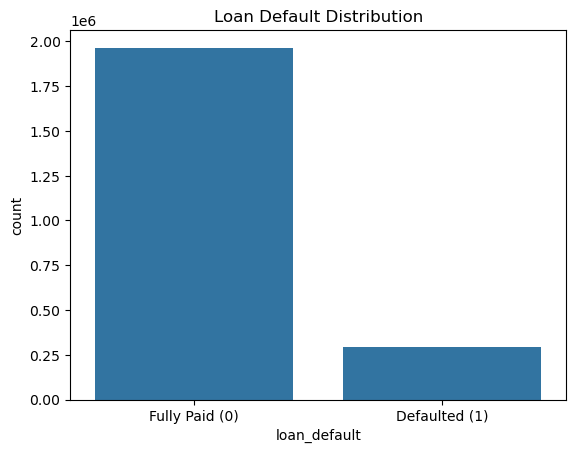

Default rate: 13.06%


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot
sns.countplot(x='loan_default', data=data)
plt.title("Loan Default Distribution")
plt.xticks([0, 1], ['Fully Paid (0)', 'Defaulted (1)'])
plt.savefig("Taret_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Percentage
default_rate = data['loan_default'].mean() * 100
print(f"Default rate: {default_rate:.2f}%")


## Univariate Analysis

#### Loan Amount vs Default

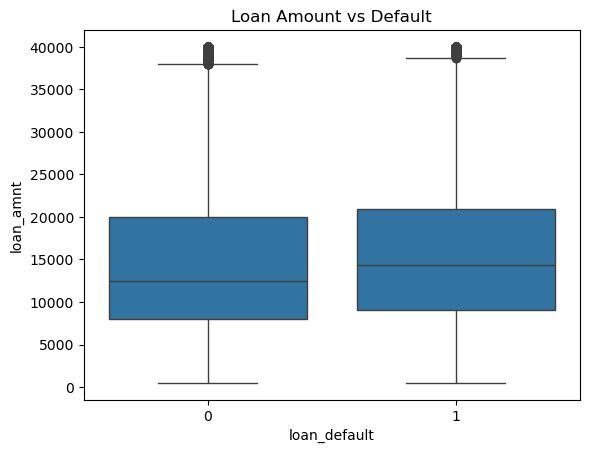

In [39]:
sns.boxplot(x='loan_default', y='loan_amnt', data=data)
plt.title("Loan Amount vs Default")
plt.savefig("Loanamountvsdefault.png", dpi=300, bbox_inches='tight')
plt.show()

####  Interest Rate vs Default

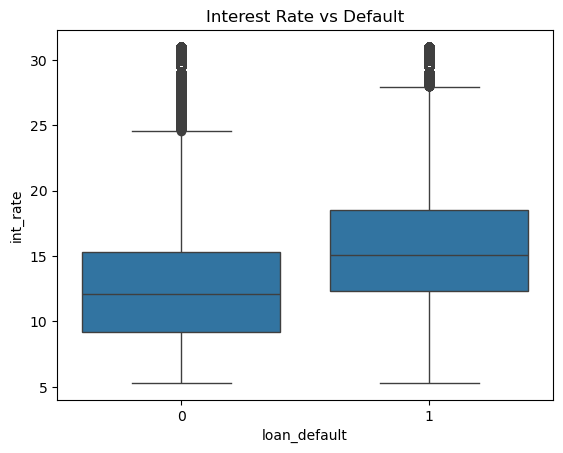

In [41]:
sns.boxplot(x='loan_default', y='int_rate', data=data)
plt.title("Interest Rate vs Default")
plt.savefig("interestratevsdefault.png", dpi=300, bbox_inches='tight')
plt.show()

#### Grade vs Default

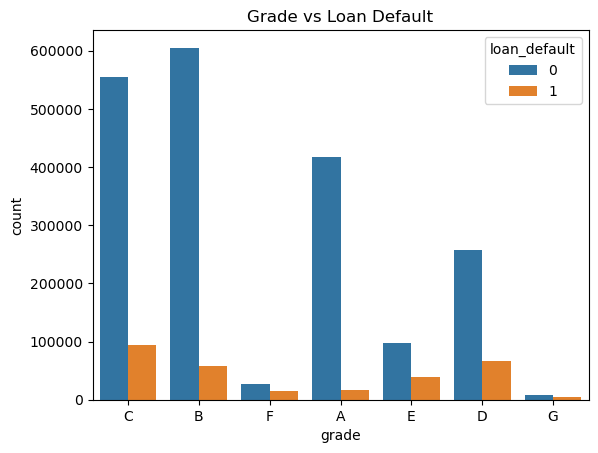

In [43]:
sns.countplot(x='grade', hue='loan_default', data=data)
plt.title("Grade vs Loan Default")
plt.savefig("gradevsdefault.png", dpi=300, bbox_inches='tight')
plt.show()

## Bivariate Analysis — Categorical Features

#### Home Ownership vs Default

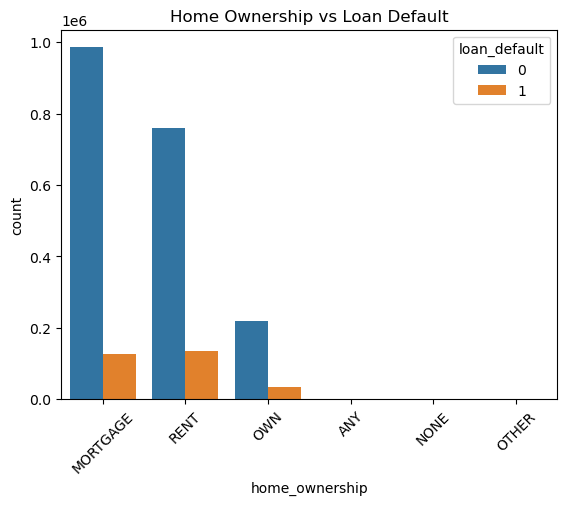

In [45]:
sns.countplot(x='home_ownership', hue='loan_default', data=data)
plt.title("Home Ownership vs Loan Default")
plt.xticks(rotation=45)
plt.savefig("HOwnershipvsloan.png", dpi=300, bbox_inches='tight')
plt.show()

#### Purpose of Loan vs Default

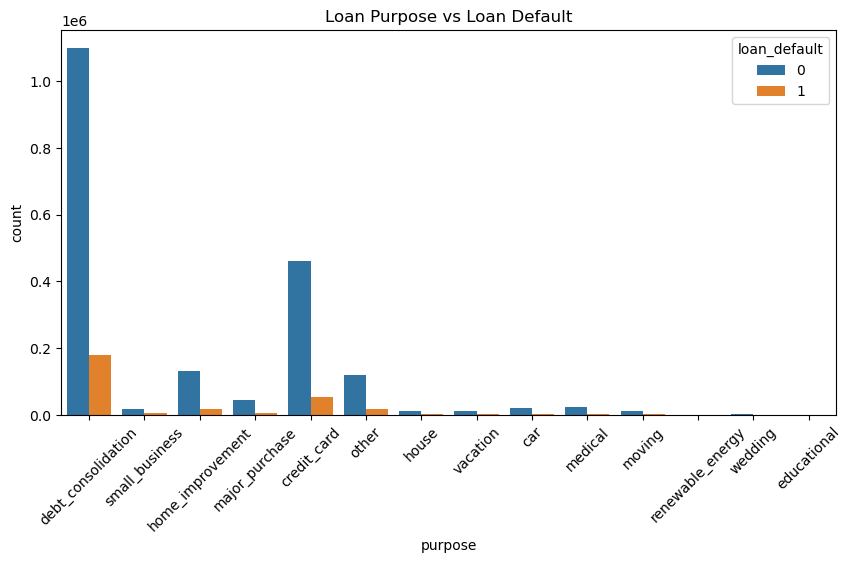

In [47]:
plt.figure(figsize=(10,5))
sns.countplot(x='purpose', hue='loan_default', data=data)
plt.title("Loan Purpose vs Loan Default")
plt.xticks(rotation=45)
plt.savefig("loanpurposevsloandefault.png", dpi=300, bbox_inches='tight')
plt.show()

## Correlation Heatmap (Numerical Features)

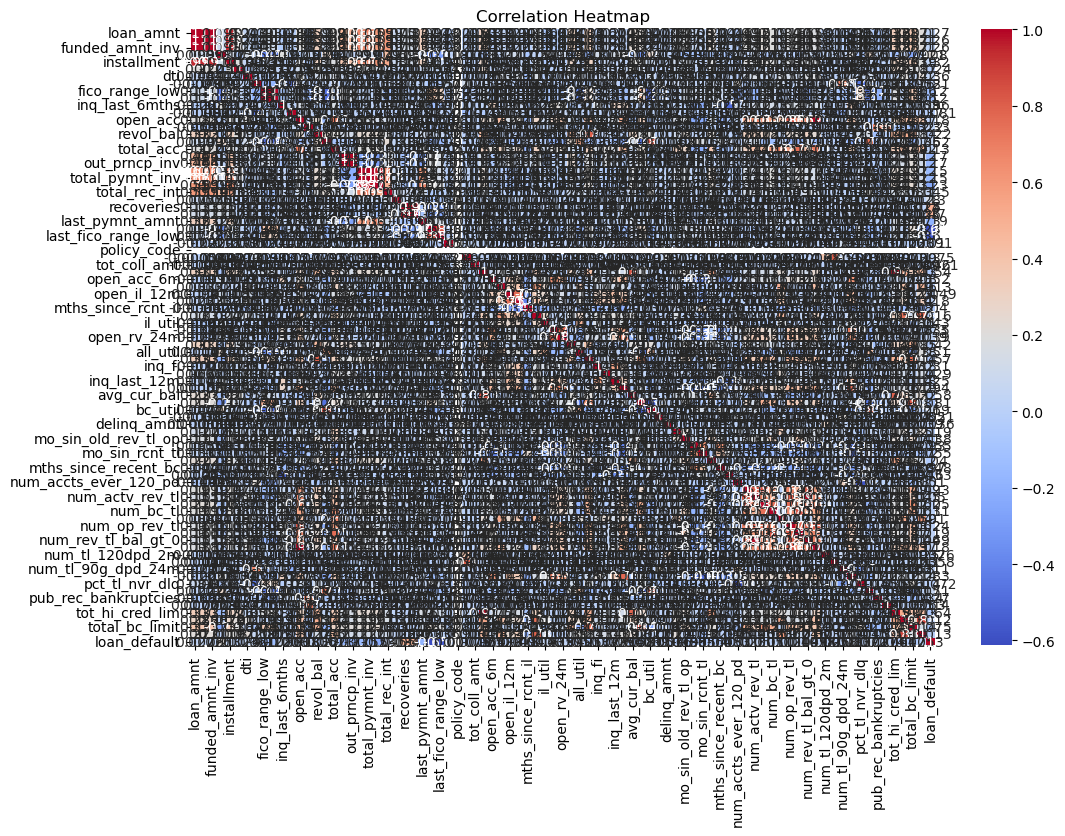

In [49]:
# Filter numerical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).drop(columns='loan_default')

# Correlation with target
correlation = data[num_cols.columns.tolist() + ['loan_default']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("heatmap01.png", dpi=300, bbox_inches='tight')
plt.show()

## Feature Selection and Encoding

#### We’ll pick useful features and convert them into a format that machine learning models understand.

#### Basic Feature Selection

In [51]:
selected_features = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'emp_length', 'home_ownership',
    'annual_inc', 'purpose', 'dti', 'delinq_2yrs',
    'revol_util', 'total_acc'
]

In [53]:
#Add the target:
data_model = data[selected_features + ['loan_default']]
data_model.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,purpose,dti,delinq_2yrs,revol_util,total_acc,loan_default
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,debt_consolidation,5.91,0.0,29.7,13.0,0
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,small_business,16.06,1.0,19.2,38.0,0
2,20000.0,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,home_improvement,10.78,0.0,56.2,18.0,0
3,35000.0,60 months,14.85,829.90,C,10+ years,MORTGAGE,110000.0,debt_consolidation,17.06,0.0,11.6,17.0,0
4,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,major_purchase,25.37,1.0,64.5,35.0,0


#### Encoding Categorical Features

In [55]:
data_model.dtypes

loan_amnt         float64
term               object
int_rate          float64
installment       float64
grade              object
emp_length         object
home_ownership     object
annual_inc        float64
purpose            object
dti               float64
delinq_2yrs       float64
revol_util        float64
total_acc         float64
loan_default        int64
dtype: object

In [57]:
data_model_encoded = pd.get_dummies(data_model, drop_first=True)
data_model_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,revol_util,total_acc,loan_default,term_ 60 months,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,3600.0,13.99,123.03,55000.0,5.91,0.0,29.7,13.0,0,False,...,False,False,False,False,False,False,False,False,False,False
1,24700.0,11.99,820.28,65000.0,16.06,1.0,19.2,38.0,0,False,...,False,False,False,False,False,False,False,True,False,False
2,20000.0,10.78,432.66,63000.0,10.78,0.0,56.2,18.0,0,True,...,True,False,False,False,False,False,False,False,False,False
3,35000.0,14.85,829.90,110000.0,17.06,0.0,11.6,17.0,0,True,...,False,False,False,False,False,False,False,False,False,False
4,10400.0,22.45,289.91,104433.0,25.37,1.0,64.5,35.0,0,True,...,False,False,True,False,False,False,False,False,False,False


#### Spliting Features and Target

In [59]:
X = data_model_encoded.drop(columns='loan_default')
y = data_model_encoded['loan_default']
print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature shape: (2260701, 43)
Target distribution:
 loan_default
0    1965525
1     295176
Name: count, dtype: int64


#### Train-Test Split

In [61]:
#Split into train and test sets (80/20 split):
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Feature Scaling

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### dataset is now Cleaned,Feature engineered, Encoded, Scaled, Splitted into training/testing sets

## Model Training and Evaluation

#### Handling Class Imbalance & Training Logistic Regression

In [65]:
# Train Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

#### Training Decision Tree

In [67]:
# Train Decision Tree
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

#### Evaluating Logistic Regression

📘 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73    393106
           1       0.20      0.68      0.31     59035

    accuracy                           0.61    452141
   macro avg       0.56      0.64      0.52    452141
weighted avg       0.83      0.61      0.68    452141

ROC-AUC Score: 0.69517762193702


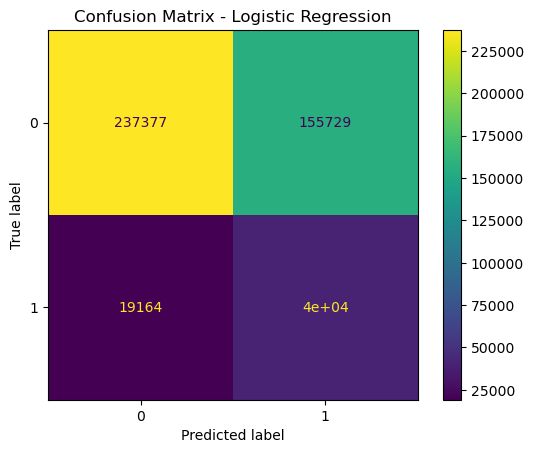

In [73]:
print("📘 Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("Logistic Regression CM.png", dpi=300, bbox_inches='tight')
plt.show()

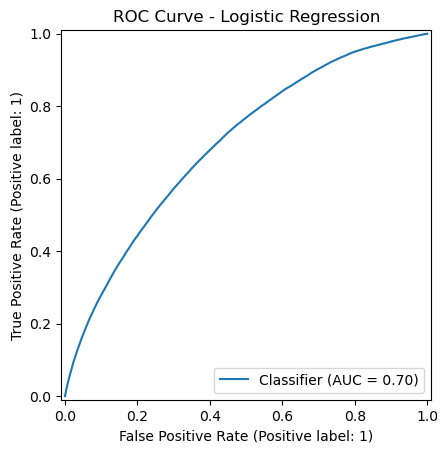

In [75]:
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title("ROC Curve - Logistic Regression")
plt.savefig("Logistic Regression ROC Curve.png", dpi=300, bbox_inches='tight')
plt.show()

#### Evaluating Decision Tree

🌲 Decision Tree Results:
              precision    recall  f1-score   support

           0       0.94      0.52      0.67    393106
           1       0.19      0.77      0.31     59035

    accuracy                           0.55    452141
   macro avg       0.57      0.64      0.49    452141
weighted avg       0.84      0.55      0.62    452141

ROC-AUC Score: 0.7030674902836299


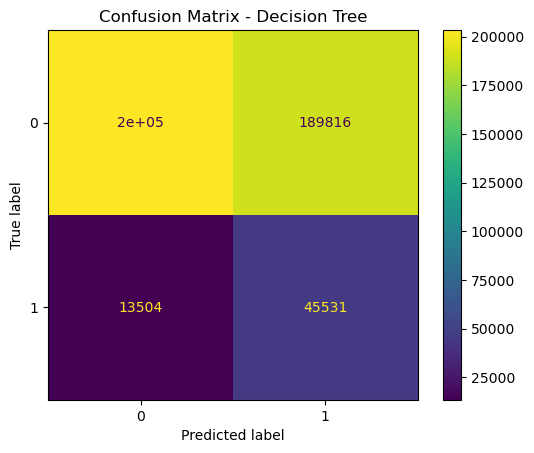

In [79]:
print("🌲 Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_dt))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.title("Confusion Matrix - Decision Tree")
plt.savefig("Decision Tree CM.png", dpi=300, bbox_inches='tight')
plt.show()


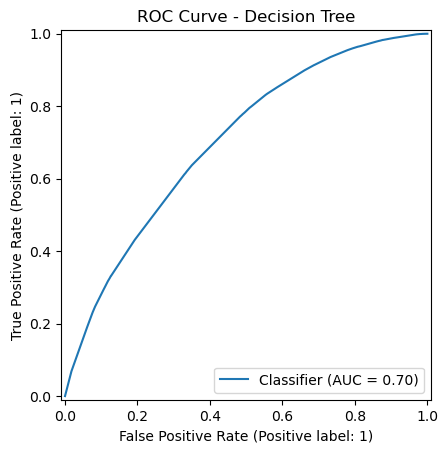

In [83]:
RocCurveDisplay.from_predictions(y_test, y_prob_dt)
plt.title("ROC Curve - Decision Tree")
plt.savefig("Decision Tree ROC.png", dpi=300, bbox_inches='tight')
plt.show()

## Handling Class Imbalance with SMOTE

#### Applying SMOTE to Training Set

In [85]:
# Only use on original (non-scaled) training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: loan_default
0    1572419
1     236141
Name: count, dtype: int64
After SMOTE: loan_default
0    1572419
1    1572419
Name: count, dtype: int64


#### Scaling Resampled Data (if needed)

In [87]:
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Reuse the same scaler

#### Logistic Regression (on resampled & scaled data):

In [89]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_resampled_scaled, y_train_resampled)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

#### Decision Tree (on resampled data):

In [91]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

#### Evaluation after SMOTE

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("📘 Logistic Regression after SMOTE:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

print("🌲 Decision Tree after SMOTE:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))

📘 Logistic Regression after SMOTE:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93    393106
           1       0.40      0.03      0.06     59035

    accuracy                           0.87    452141
   macro avg       0.63      0.51      0.49    452141
weighted avg       0.81      0.87      0.81    452141

ROC-AUC: 0.662933721769828
🌲 Decision Tree after SMOTE:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87    393106
           1       0.21      0.26      0.23     59035

    accuracy                           0.78    452141
   macro avg       0.55      0.56      0.55    452141
weighted avg       0.80      0.78      0.79    452141

ROC-AUC: 0.6517380118244439


## Advanced Models – XGBoost & Random Forest

In [119]:
##Dependencies
!pip install xgboost --quiet

#### Train-Test Preparation

In [121]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    max_depth=10  # you can tune later
)

rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [123]:
# Clean column names in train and test features
X_train_resampled.columns = X_train_resampled.columns.str.replace(r"[\[\]<>]", "", regex=True)
X_test.columns = X_test.columns.str.replace(r"[\[\]<>]", "", regex=True)

In [125]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:51:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

#### Evaluating Both Models

In [129]:
# Make sure XGBoost model is trained
# If not done already:
# xgb_model.fit(X_train_resampled, y_train_resampled)

# Generate predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [131]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
# Random Forest
print("🌳 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
# XGBoost
print("⚡ XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

🌳 Random Forest Results:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90    393106
           1       0.27      0.20      0.23     59035

    accuracy                           0.83    452141
   macro avg       0.58      0.56      0.57    452141
weighted avg       0.80      0.83      0.81    452141

ROC-AUC: 0.6765120659512924
⚡ XGBoost Results:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    393106
           1       0.42      0.01      0.02     59035

    accuracy                           0.87    452141
   macro avg       0.65      0.50      0.48    452141
weighted avg       0.81      0.87      0.81    452141

ROC-AUC: 0.6905653957389503
